In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr

def one_hot_encode(seq, maxlen=30):
    mapping = {'A':[1,0,0,0], 'C':[0,1,0,0], 'G':[0,0,1,0], 'T':[0,0,0,1]}
    seq = seq.upper()[:maxlen].ljust(maxlen, 'N')
    return np.array([mapping.get(b,[0,0,0,0]) for b in seq], dtype=np.float32)
def align_sequences(s1, s2, match_len, maxlen):
    best_score, best_i, best_j = -1,0,0
    for i in range(len(s1)-match_len+1):
        for j in range(len(s2)-match_len+1):
            sc = sum(a==b for a,b in zip(s1[i:i+match_len], s2[j:j+match_len]))
            if sc>best_score:
                best_score, best_i, best_j = sc, i, j
    c1 = best_i + match_len//2
    c2 = best_j + match_len//2
    def crop(s,c):
        start = c - maxlen//2
        if start<0:
            s = 'N'*(-start) + s
            start=0
        out = s[start:start+maxlen]
        return out.ljust(maxlen,'N')
    return crop(s1,c1), crop(s2,c2)

class GuideRNADataset(Dataset):
    def __init__(self, df, match_len=5, maxlen=30):
        self.match_len = match_len
        self.maxlen = maxlen
        # use the real column names:
        self.contexts = df['TargetSeqContext'].astype(str).tolist()
        self.guides   = df['GuideSeq'].astype(str).tolist()
        self.labels   = df['log2FC'].astype(np.float32).values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        s1, s2 = self.contexts[idx], self.guides[idx]
        # align
        a1, a2 = align_sequences(s1, s2, self.match_len, self.maxlen)
        # one‐hot
        x1 = one_hot_encode(a1, self.maxlen)  # (maxlen,4)
        x2 = one_hot_encode(a2, self.maxlen)
        # concat → (maxlen,8)
        x  = np.concatenate([x1, x2], axis=1)
        return torch.from_numpy(x), torch.tensor(self.labels[idx])

# --- BiLSTM with Attention ---
class BiLSTM_Attn(nn.Module):
    def __init__(self, input_size=8, hidden_size=128, num_layers=2):
        super(BiLSTM_Attn, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.attn_linear = nn.Linear(hidden_size*2, 1)
        self.fc = nn.Linear(hidden_size*2, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # [B, L, 2H]
        attn_weights = torch.softmax(self.attn_linear(lstm_out), dim=1)  # [B, L, 1]
        context = torch.sum(attn_weights * lstm_out, dim=1)  # [B, 2H]
        out = self.fc(context)  # [B, 1]
        return out.squeeze(1)

# --- Load Data ---
df = pd.read_csv("final_activity_dataset.csv").dropna()
genes = df['GeneName'].unique()
holdout_genes = np.random.choice(genes, size=375, replace=False)

df_test = df[df['GeneName'].isin(holdout_genes)].reset_index(drop=True)
df_train = df[~df['GeneName'].isin(holdout_genes)].reset_index(drop=True)

train_dataset = GuideRNADataset(df_train)
test_dataset = GuideRNADataset(df_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- Train ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM_Attn().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(20):
    model.train()
    train_losses = []
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = loss_fn(pred, y)
            val_losses.append(loss.item())

    print(f"Epoch {epoch+1}: Train Loss={np.mean(train_losses):.4f}, Val Loss={np.mean(val_losses):.4f}")

# --- Evaluate ---
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        pred = model(x).cpu().numpy()
        all_preds.extend(pred)
        all_labels.extend(y.numpy())

y_pred = np.array(all_preds)
y_true = np.array(all_labels)

# --- Metrics ---
print("Pearson:", pearsonr(y_true, y_pred)[0])
print("Spearman:", spearmanr(y_true, y_pred)[0])
print("R2 Score:", r2_score(y_true, y_pred))


Epoch 1: Train Loss=0.9688, Val Loss=1.3928
Epoch 2: Train Loss=0.9055, Val Loss=1.4050
Epoch 3: Train Loss=0.8672, Val Loss=1.4243
Epoch 4: Train Loss=0.8216, Val Loss=1.4723


KeyboardInterrupt: 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 869.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

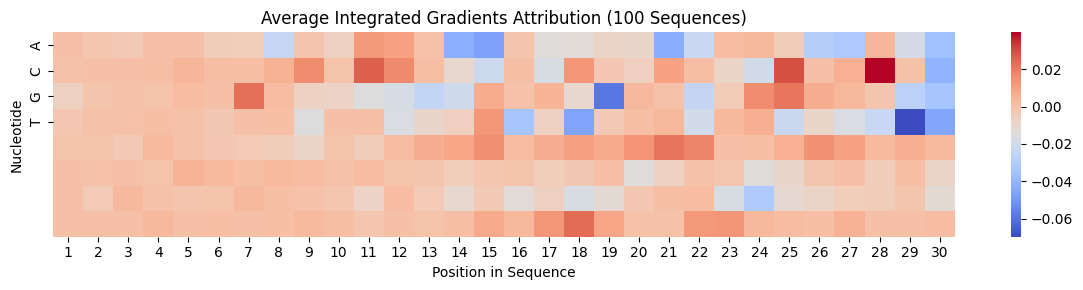

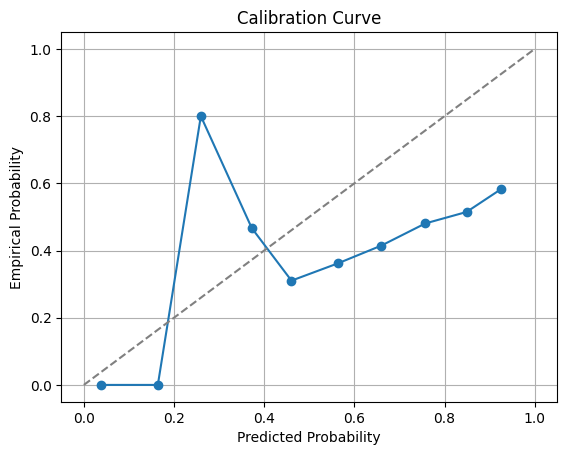

=== Evaluation Metrics ===
Pearson: 0.10240419
Spearman: 0.10227693211941047
R2 Score: -0.08770906925201416
AUROC: 0.5544581502457917
AUPRC: 0.5466489885894258


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_auc_score, average_precision_score
from scipy.stats import pearsonr, spearmanr

# ------------- Evaluate Predictions -------------
model.eval()
all_preds, all_labels, all_inputs = [], [], []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_inputs.append(x.cpu())

X_test_tensor = torch.cat(all_inputs)
y_pred = np.array(all_preds)
y_true = np.array(all_labels)

# ------------- Integrated Gradients -------------
model.train()

# Collect input tensors
X_test_tensor = torch.stack([x for x, _ in test_dataset])[:100].to(device).requires_grad_()

# Define baseline (zero vector)
baseline = torch.zeros_like(X_test_tensor).to(device)

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Compute attributions for all 100 samples
attributions, delta = ig.attribute(X_test_tensor, baselines=baseline, return_convergence_delta=True)

# Average attribution across examples
avg_attr = attributions.detach().cpu().numpy().mean(axis=0).T  # shape: [4, 30]

# Plot the heatmap
plt.figure(figsize=(12, 3))
sns.heatmap(avg_attr, cmap="coolwarm", xticklabels=range(1, 31), yticklabels=["A", "C", "G", "T"])
plt.title("Average Integrated Gradients Attribution (100 Sequences)")
plt.xlabel("Position in Sequence")
plt.ylabel("Nucleotide")
plt.tight_layout()
plt.show()

# ------------- Calibration Curve -------------
y_bin = (y_true > np.median(y_true)).astype(int)
y_pred_norm = (y_pred - y_pred.min()) / (y_pred.max() - y_pred.min())  # normalize

prob_true, prob_pred = calibration_curve(y_bin, y_pred_norm, n_bins=10)

plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("Predicted Probability")
plt.ylabel("Empirical Probability")
plt.title("Calibration Curve")
plt.grid(True)
plt.show()

# ------------- Metrics -------------
print("=== Evaluation Metrics ===")
print("Pearson:", pearsonr(y_true, y_pred)[0])
print("Spearman:", spearmanr(y_true, y_pred)[0])
print("R2 Score:", r2_score(y_true, y_pred))
print("AUROC:", roc_auc_score(y_bin, y_pred_norm))
print("AUPRC:", average_precision_score(y_bin, y_pred_norm))
